In [10]:
import pstats
import random as rnd
import numpy as np
from pymoo.util.normalization import standardize
import pandas as pd
from pymoo.visualization.scatter import Scatter
from pymoo.optimize import minimize
import matplotlib.pyplot as plt
from pymoo.indicators.hv import HV
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.survival.rank_and_crowding import RankAndCrowding
import time
import warnings
from pymoo.operators.mutation.inversion import InversionMutation
from pymoo.core.mutation import Mutation
from pymoo.core.callback import Callback
import optuna
import seaborn as sns
from scipy import stats
import itertools

# Script Principal
Mediante el este script, se presenta todo el código necesario para el funcionamiento de el Algoritmo NSGA II Personalizado. Para el manejo de vectores, matrices y todas las posibles manipulaciones que se hagan se va a hacer uso de la libreria Numpy. Por otro lado, para la ejecución del algoritmo NSGA-II y todo lo relacionado con la modelización multiobjetivo, se va a utilizar la libreria Pymoo.

## Cargamos los datos
Se cargan las notas de los alumnos, resultados del test MTBI y Genero de los estudiantes 

In [11]:
# Cargamos las tablas con las notas
for i in range(1, 3):
    for j in range(1, 5):
        # Nombre de la variable
        nombre_variable = f'R{i}{j}'

        # Nombre del archivo CSV
        path = f'Datos/R{i}{j}.csv'
        
        # Cargar la tabla desde el archivo CSV y asignarla a la variable con el nombre correspondiente
        globals()[nombre_variable] = np.loadtxt(path, delimiter=',')
        
#Cargamos las tablas con los generos
for i in range(1, 3):
    for j in range(1, 5):
        # Nombre de la variable
        nombre_variable = f'G{i}{j}'

        # Nombre del archivo CSV
        path = f'Datos/G{i}{j}.csv'
        
        # Cargar la tabla desde el archivo CSV y asignarla a la variable con el nombre correspondiente
        globals()[nombre_variable] = np.loadtxt(path, delimiter=',')

def Prop_aula(G):
    
    Prop = float(np.mean(G))
    return Prop

#Cargamos las tablas con los datos del test test MTBI
K=np.loadtxt("Datos/K", delimiter=',')

Prop_aula(G14[:41])


0.21951219512195122

## Función para formación de equipos


In [12]:
def formar_equipos(vector_permutacion):   #Dado una lista permutada de alumnos configuramos los alumnos en equipos de 4 y si hace falta de 5
    
    equipos = vector_permutacion.reshape(-1, 4)
    
    return equipos

formar_equipos(np.arange(1,21)) #Demostración del funcionamiento

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12],
       [13, 14, 15, 16],
       [17, 18, 19, 20]])

### Funciones objetivo
Son 3 las funciones objetivo con las que se va a trabajar en el presente problema.
- GH_team: Función para medir la aptitud técnica del equipo.
- P_team: Función para medir la diversidad psicológica del equipo.
- BG_team: Función para medir el Balance de género del equipo.

In [13]:
def GH_team(Ri,r_max,r_min, r_mean):
    #Contamos los valores unicos en las notas de los 4 integrantes, por si hay notas repetidas
    unique_values, counts = np.unique(Ri, return_counts=True)
    
    # Calculamos AD(ti)
    ADi = (np.max(Ri) - np.min(Ri)) / 2
    # Calculamos GH(ti)
    # Calcular la puntuación técnica más alta y más baja para el equipo i
    max_puntuacion = np.max(Ri)
    min_puntuacion = np.min(Ri)
    #print(f" Puntuaciones max: {max_puntuacion}")
    #print(f" Puntuaciones min: {min_puntuacion}")
    
    # Excluir las puntuaciones más altas y más bajas del cálculo de GH
    puntuaciones_excluidas = np.setdiff1d(unique_values, [max_puntuacion, min_puntuacion])
    repetidos = unique_values[counts > 1]
    #print(f"repetidos: {repetidos}")
    
    if len(repetidos) > 0:
        
        # Si hay valores repetidos
        puntuaciones_excluidas = np.append(puntuaciones_excluidas, repetidos[0])
        
        # Si todos los alumnos tienen la misma nota, lo agregamos dos veces a puntuaciones_excluidas
        if counts[0] == 4:
            puntuaciones_excluidas = np.append(puntuaciones_excluidas, repetidos[0])
        # Si 3 de los alumnos tienen la misma nota
        elif np.any(counts == 3):  
            puntuaciones_excluidas = np.append(puntuaciones_excluidas, repetidos[0])
            
        elif len(repetidos) > 1:
            # Si hay más de un valor repetido, agregamos el segundo valor repetido como puntuación excluida
            puntuaciones_excluidas = np.append(puntuaciones_excluidas, repetidos[1])
            
    #print(f" Puntuaciones excluidas: {puntuaciones_excluidas}")
    restas = np.abs(ADi - puntuaciones_excluidas)
    GHi = (np.max(Ri) - np.min(Ri)) / (1 + np.sum(restas))
    #print(f"GHi: {GHi}")
    
    #Calculamos el GHi maximo que se puede obtener segun las notas de la clase
    AD_max = (r_max-r_min) / 2
    restas_max = AD_max-r_mean
    GHi_max = (r_max-r_min) / (1 + np.abs(2*restas_max))
    #print(f"GHi_max: {GHi_max}")
    return GHi/GHi_max



def P_team(Ki):
    # Calculamos el vector P
    suma_perfiles = np.sum(Ki, axis=0)
    num_alumnos = np.shape(Ki)[0]
    
    # Inicializamos el vector P_k
    P_k = np.zeros_like(suma_perfiles)
    
    # Si todos tienen el mismo perfil le damos un 0 en esa dimensión
    P_k[np.abs(suma_perfiles) == num_alumnos] = 0
    
    # Si todos menos un individuo tienen el mismo perfil le damos un 1 a esa dimensión
    P_k[np.abs(suma_perfiles) >= num_alumnos - 2] = 1
    
    # Para los demás casos le damos un 2 a esa dimensión
    P_k[(np.abs(suma_perfiles) < num_alumnos - 2) & (np.abs(suma_perfiles) > 0)] = 2
    
    # Calculamos el indice de divergencia psicológica para ese equipo
    P_ti = np.sum(P_k)
    
    return P_ti/8

def BG_team(Gi, P_aula):
    #print(f"Gi: {Gi}")
    #Proporcion de mujeres en el equipo
    P_equipo=float(np.mean(Gi))
    Divisor =max(P_aula, 1 - P_aula)
    BG_ti = 1-(abs(P_aula - P_equipo)/ Divisor)
    #print(f"Prop clase: {P_aula}")
    #print(f"Prop_equipo: {P_equipo}")
    return BG_ti

In [14]:
#Ejemplo de uso para la función de Aptitud técnica
maxi = np.max(R11)
print(f"max: {maxi}")
mini = np.min(R11)
print(f"min: {mini}")
meani = np.mean(R11)
print(f"mean: {meani}")

print(f"Equipo: {R11[[23,42, 30, 31]]}")
GH_team(R11[[23,42, 30, 31]],maxi, mini ,meani)

max: 10.0
min: 4.3
mean: 6.300375939849625
Equipo: [5.9 7.5 7.9 4.9]


0.36476232131575476

## Funciónes objetivo a nivel Solución
En nuestro problema, una solución se define como una partición de la clase en equipos de 4 integrantes. Para medir la calidad de estas soluciones, se hace uso del valor resultante del producto de cada  dimensión descrita anteriormente. Cabe puntualizar que, se les atribuye un valor negativo debido a que Pymoo solo trabaja con la minimización de objetivos, por lo que para maximizar una función objetivo hay que convertirla en negativa.

In [15]:
def fitness_particion(fitness_equipos):
    
    GHs = fitness_equipos[:,0]
    #print(f"GHs: {GHs}")
    AT_sol = np.prod(GHs)
    # P solucion
    Ps = fitness_equipos[:,1]
    #print(f"Ps: {Ps}")
    P_sol= float( np.prod(Ps))
    
    # BG solucion
    BGs = fitness_equipos[:,2]
    #print(f"BGs: {BGs}")
    BG_sol= np.prod(BGs)

    return np.array([-AT_sol, -P_sol, -BG_sol])  

## Definición del problema

Mediante el modulo problem, definimos el problema a solucionar. En este caso, como el problema es multiobjetivo al final de el metodo TFP._evaluate() se define el termino out[F], en el cual guardamos el vector con los 3 fitness atribuidos a cada solución. 
Cabe puntualizar que, se hace uso de 2 diccionarios para guardar en uno los fitness de los equipos tratados (team_fitness_dict) y en otro el fitness de las soluciones (solution_fitness_dict). Mediante estos dos diccionarios, conseguimos reducir el tiempo de ejecución de nuestro algoritmo considerablemente, debido a que muchas de las soluciones deberian de ser evaluadas repetidamente por las rutinas que maneja el algoritmo, y mediante los diccionarios evitamos dichos recalculos guardando los equipos y soluciones con sus respectivos fitness en los diccionarios adecuados.
   

In [23]:
from pymoo.core.problem import Problem 

class TFP(Problem):
    def __init__(self, n_var, R, K, G):
        super().__init__(n_var=n_var, n_obj=3, xl=1, xu=n_var)
        self.R = R[:n_var+1]
        self.K = K[:n_var+1]
        self.G = G[:n_var+1]
        self.P_aula = Prop_aula(self.G)
        self.team_fitness_dict = {} # Diccionario para guardar los equipos con su fitness
        self.solution_fitness_dict={} #Diccionario para guardar las soluciones con su fitness
        
    def _evaluate(self, X, out, *args, **kwargs):
        num_solutions = X.shape[0]
        
        Fitness_pop = np.zeros([num_solutions,3]) #Inicializamos la matriz para guardar el fitness de las soluciones
        
        for i in range(num_solutions): #Iteramos sobre cada solución
            
            solucion_actual = X[i, :]  
            # Lo convertimos en frozenset para que pueda utilizarse como key al ser un objeto inmutable y pq no queremos que tenga en cuenta el orden de los alumnos en el equipo
            if frozenset(solucion_actual) in self.solution_fitness_dict:# Si la solucion esta en el diccionario no calcular fitness
                Fitness_pop[i] = self.solution_fitness_dict[frozenset(solucion_actual)]             
            else:
                equipos = formar_equipos(solucion_actual)
                fitness_equipos = np.zeros([equipos.shape[0],3]) #inicializamos la matriz para guardar el fitness de los equipos
            
                #Iteramos sobre cada equipo de la solución actual
                for j in range(0, equipos.shape[0]):  
            
                    ti = equipos[j]
                    # Lo convertimos en frozenset para que pueda utilizarse como key al ser un objeto inmutable y pq no queremos que tenga en cuenta el orden de los alumnos en el equipo
                    if frozenset(ti) in self.team_fitness_dict: # Si el equipo esta en el diccionario no calcular fitness
                        fitness_ti = self.team_fitness_dict[frozenset(ti)]
                        fitness_equipos[j] =  fitness_ti
                    
                    else:
                        # guardamos los datos necesarios para el calculo de los fitness
                        r_max = np.max(self.R)
                        r_min =np.min(self.R)
                        r_mean =np.mean(self.R)
                        Ri = self.R[ti]
                        Ki = self.K[ti]
                        Gi = self.G[ti]
                
                        GH_equipo = GH_team(Ri,r_max, r_min, r_mean)
                        P_equipo = P_team(Ki)
                        BG_equipo = BG_team(Gi, self.P_aula) 
                        fitness_ti = np.array([GH_equipo, P_equipo, BG_equipo])
                        fitness_equipos[j] =  fitness_ti
                        self.team_fitness_dict[frozenset(ti)] = fitness_ti #Introducimos el fitness del equipo nuevo en el diccionario para futuros casos
                Fitness_C = fitness_particion(fitness_equipos)   
                Fitness_pop[i] = Fitness_C #Guardamos el fitness de la población actual en su fila correspondiente
        out["F"] = np.row_stack([Fitness_pop])         
        

## Operador de Muestreo personalizado

Creamos un operador de Sampling para crear nuestro poblacion de soluciones inicial mediante la libreria Pymoo

In [25]:
import numpy as np
from pymoo.core.sampling import Sampling

class PermutationSampling(Sampling):
    def __init__(self, problem, n_samples):
        super().__init__()
        self.problem = problem
        self.n_samples = n_samples

    def _do(self, problem, n_samples, **kwargs):
        X = np.full((n_samples, problem.n_var), -1, dtype=int)

        for k in range(n_samples):
            X[k, :] = np.random.permutation(range(1, problem.n_var + 1))
            
        return X

## Operador de cruce personalizado
Se ha tomado como ejemplo el operador OrderCrossover ya implementado en Pymoo, siguiendo la misma estructura : https://github.com/anyoptimization/pymoo/blob/main/pymoo/operators/crossover/ox.py

In [26]:

from pymoo.core.crossover import Crossover
from sklearn import preprocessing

# Definimos el algoritmo de la ruleta que vamos a utilizar para elegir el equipo candidato a formar una nueva solucion
class RouletteWheelSelection:

    def __init__(self, val, larger_is_better=True):
        super().__init__()
        if not larger_is_better:
            val = val.max() - val
        _sum = val.sum()
        self.cumulative = np.array([val[:k].sum() / _sum for k in range(1, len(val))])

    def next(self):
        
        X = np.random.random((1, 1))
        
        #print(f"num rueda: {X}")
        M = self.cumulative[None, :].repeat(len(X), axis=0)
        #print(f"M: {M}")
        B = X >= M
        ret = B.sum(axis=1)[0]
        #print(f" Equipo seleccionado: {ret}")
        
        return ret
    

#Funcion para convertir alumnos repetidos en 0 a partir de la segunda ocurrencia
# Crear un array numpy con 20 números aleatorios del 1 al 10
def generar_alumnos_no_presente(alumnos_presentes, n_var):
    
    alumnos_todos = np.arange(1, n_var + 1)
    #print(f"alumnos presentes: {alumnos_presentes}")
    alumnos_posibles = np.setdiff1d(alumnos_todos,alumnos_presentes)
    #print(f"alumnos no incluidos: {alumnos_posibles}")
    # Encontrar los valores únicos y contar cuántas veces aparece cada uno
    valores_unicos, cuentas = np.unique(alumnos_presentes, return_counts=True)
    #print(f"valores unicos: {valores_unicos}")
    #print(f"cuentas: {cuentas}")
    
    # Crear una máscara para los valores que deben cambiarse a 0 a partir de la segunda ocurrencia
    mascara_repetidos = np.zeros_like(alumnos_presentes, dtype=bool)
    for valor in valores_unicos:
        indices_valor = np.where(alumnos_presentes == valor)[0]
        mascara_repetidos[indices_valor[1:]] = True
    #print(f"mascara repetidos: {array_numeros[mascara_repetidos]}")
    
    # Cambiar los valores repetidos a partir de la segunda ocurrencia
    alumnos_presentes[mascara_repetidos] = alumnos_posibles
    #print(f"permutacion final: {alumnos_presentes}")
    return alumnos_presentes


class CustomCrossover(Crossover):
    def __init__(self, *args, **kwargs):
        super().__init__(2, 1, *args, **kwargs)  # Numero de padres=2 numero de hijos=1

    def _do(self, problem, X, **kwargs):

        # Cada fila representa un padre, cada columna una variable(alunmno)
        _, n_matings, n_var = X.shape

        # Inicializar la matriz de descendencia
        Y = np.zeros((1, n_matings, n_var), dtype=int)

        for k in range(0, n_matings):
            #print(f"mating numero {k}")
            #Seleccionar dos padres
            P1, P2 = X[:, k, :]

            # Generamos el vector para guardar los equipos de ambos padres
            #print(f"padre 1: {P1}")
            #print(f"padre 2: {P2}")
            Equipos_P1 = formar_equipos(P1)
            Equipos_P2 = formar_equipos(P2)
            n_equipos = len(Equipos_P1)
            Equipos_P1_P2 = np.concatenate((Equipos_P1, Equipos_P2))  # Matriz con los equipos de ambos padres

            # Inicializamos vector de equipos seleccionados y vector de fitness de los equipos
            alumnos_seleccionados = np.empty(0)
            fitness_P1_P2 = np.empty((0, 3))
            indices_selec = set()
            # Generamos el vector con los fitness de los equipos de ambos padres
            for equipo_actual in Equipos_P1_P2:
                equipo_actual_frozenset = frozenset(equipo_actual)
                #print(f"equipo actual: {equipo_actual}")
                fitness_equipo = problem.team_fitness_dict[
                    equipo_actual_frozenset]  # Sacamos el fitness del diccionario, puesto que ya se han calculado en el evaluate del TFP
                #print(f"fitness del equipo actual: {fitness_equipo}")
                fitness_P1_P2 = np.vstack((fitness_P1_P2, fitness_equipo))
            #print(f"matriz fitness antes de reescalar: {fitness_P1_P2}")

            # Normalizar por columnas
            fitness_P1_P2 = preprocessing.normalize(fitness_P1_P2,axis=0)
            #print(f"matriz fitness tras reescalar: {fitness_P1_P2}")
            fitness_P1_P2 = np.dot(fitness_P1_P2, [0.5, 0.5, 0.5])
            
            selector = RouletteWheelSelection(fitness_P1_P2)
            for i in range(0, n_equipos):
                # Actualizamos el ranking y seleccionamos un equipo segun este
                #print(f"Equipos: {Equipos_P1_P2}")
                #print(f"Fitness de los equipos: {fitness_P1_P2}")
                arg_selec = selector.next()
                while arg_selec in indices_selec:
                    arg_selec = selector.next()
                indices_selec.add(arg_selec)
                ti_selec = Equipos_P1_P2[arg_selec]
                #print(f"Equipo seleccionado: {ti_selec}")
                alumnos_seleccionados = np.concatenate((alumnos_seleccionados, ti_selec))
                
            alumnos_seleccionados = generar_alumnos_no_presente(alumnos_seleccionados, n_var)

            #print(f"padre 1: {P1}")
            #print(f"padre 2: {P2}")
            #print(f"Hijo generado: {alumnos_seleccionados}")
            # Añadimos el hijo a la matriz de hijos Y
            Y[0, k, :] = alumnos_seleccionados

        return Y

# Operador de mutación personalizado

Este operdor de mutación consiste en escoger aleatoriamente "a" equipos, siendo "a" un numero de 2 a el numero de equipos en la solución. Tras escoger dichos equipos, se redistribuyen aleatoriamente creando "a" nuevos equipos. Estos nuevos equipos reemplazan en la solución a los equipos originales.

In [27]:
class CustomMutation(Mutation):

    def __init__(self, prob):
        super().__init__()
        self.prob = prob

    def _do(self, problem, X, **kwargs):
        Y = X.copy()
        
        # Iterar sobre cada solución en la población
        for i in range(len(Y)):
            if np.random.random() < self.prob:
                #print(f"MUTACION EN {i} REALIZADA!")
                #print(f"solución {i}: {Y[i]}")
                equipos = formar_equipos(Y[i])
                #print(f"Equipos formados: {equipos}")
                num_teams = equipos.shape[0]
                a = np.random.randint(2, num_teams+1)
                #print(f"a: {a}")
                np.random.shuffle(equipos)
                # Seleccionar las primeras a filas
                equipos_selec = equipos[:a]
                #print("\nequipos_selec:")
                #print(equipos_selec)
                
                # Eliminar las filas seleccionadas del array original
                equipos = equipos[a:]
                #print(f" Equipos con equipos selec quitados: {equipos}")
                
                #Lo pasamos a permutacion
                equipos = equipos.reshape(-1)
                perm = equipos_selec.reshape(-1)
                #print(f"equipos selec plano: {perm}")
                
                # Crear una permutación aleatoria de los elementos
                perm = np.random.permutation(perm)
                #print(f"Random shuffle: {perm}")
                # Combina las sublistas de las dos listas
                Y[i] = np.concatenate((equipos, perm))
                #print(f"solucion final: {Y[i]}")
                

        return Y

### Operador de cruce Cut and Crossfill

Operador de cruce muy utilizado en problemas donde la solución se representa como una permutación. es el operador que se ve a utilizar a modo comparativo para ver si nuestra propuesta es mejor que los típicos operadores de cruce y mutación utilizados en este tipo de problemas.

In [28]:
import numpy as np

from pymoo.core.crossover import Crossover
from pymoo.util.misc import crossover_mask

def _create_offspring( parent1, parent2, cut_point):
        offspring = np.full_like(parent1, -1)

        # Copy the first part from parent 1
        offspring[:cut_point] = parent1[:cut_point]

        # Insert values from parent 2 starting from the crossover point
        idx = cut_point
        for value in parent2[cut_point:]:
            if value not in offspring:
                offspring[idx] = value
                idx += 1

        # Insert values from parent 2 starting from the beginning if necessary
        for value in parent2:
            if value not in offspring:
                offspring[idx] = value
                idx += 1

        return offspring

class CutAndCrossfillCrossover(Crossover):
    
    def __init__(self, **kwargs):
        super().__init__(2, 2, **kwargs)
        
    def _do(self, problem, X, **kwargs):
        _, n_matings, n_var = X.shape
        
        # Allocate memory for the offspring
        _X = np.full((self.n_offsprings, n_matings, n_var), -1, dtype= int)

        for k in range(n_matings):
            # Choose two parents
            p1, p2 = X[0, k], X[1, k]
        
            # Choose a random crossover point
            cut_point = np.random.randint(1, n_var)
            
            # Create offspring 1
            offspring1 = _create_offspring(p1, p2, cut_point)
            _X[0, k] = offspring1
            
            # Create offspring 2
            offspring2 = _create_offspring(p2, p1, cut_point)
            _X[1, k] = offspring2
            
        return _X

### Clase Callback
Definimos una clase de callback para poder registrar la evolución del hipervolumen de generación en generación, permitiendo comparar la velocidad de convergencia de nuestro algoritmo NSGA II con operadores personalizados con uno estandar.

In [29]:
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

# Definimos una clase de callback para registrar el hipervolumen en cada generación
class MyCallback(Callback):
    def __init__(self) -> None:
        super().__init__()
        self.hypervolume_history = np.empty(0)
        self.hv = HV(ref_point=[1,1,1]) 
        
    def notify(self, algorithm):
        # Obtiene el hipervolumen de la población actual
        
        non_dom_idx = NonDominatedSorting().do(algorithm.pop.get("F"), only_non_dominated_front=True) # Nos quedamos solamente con las soluciones no dominadas
        F = algorithm.pop.get("F")
        hv = self.hv(F)
        print(len(F))
        # Registra el hipervolumen en el historial
        self.hypervolume_history = np.append(self.hypervolume_history, hv)

In [30]:

# Crear el problema y el algoritmo con los hiperparámetros sugeridos
n_var, R, G = [80, R14, G14]
problema= TFP(n_var, R, K, G)
    
# Crear una instancia de la clase PermutationSampling
n_samples = 50
sampling = PermutationSampling(problema, n_samples)

algoritmo_nsga2 = NSGA2(
    pop_size=50,
    sampling = sampling,
    crossover = CustomCrossover(prob = 0.77),
    mutation = CustomMutation(prob = 0.057),
    survival = RankAndCrowding(crowding_func="mnn"),
    eliminate_duplicates = True,
    verbose=True,
    callback=MyCallback()
    )

result = minimize(problema,algoritmo_nsga2,("time", "00:01:00"), verbose=True)

algoritmo_nsga2_simple = NSGA2(
    pop_size=50,
    sampling = sampling,
    crossover = CutAndCrossfillCrossover(prob =  0.77),
    mutation = InversionMutation(prob = 0.057),
    survival = RankAndCrowding(crowding_func="mnn"),
    eliminate_duplicates = True,
    verbose=True,
    callback=MyCallback()
    )

result1 = minimize(problema,algoritmo_nsga2_simple,("time", "00:01:00"), verbose=True)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       50 |      5 |             - |             -
50
     2 |      100 |     10 |  0.4852595583 |         ideal
50
     3 |      150 |     11 |  0.0355865003 |         ideal
50
     4 |      200 |     14 |  0.0362554113 |         nadir
50
     5 |      250 |     20 |  0.0233454729 |         ideal
50
     6 |      300 |     25 |  0.0282194343 |         ideal
50
     7 |      350 |     15 |  0.4133070147 |         ideal
50
     8 |      400 |     14 |  0.0108581960 |         nadir
50
     9 |      450 |     16 |  0.4842249657 |         ideal
50
    10 |      500 |     21 |  0.0327788901 |             f
50
    11 |      550 |     20 |  0.8276595592 |         ideal
50
    12 |      600 |     21 |  0.0086698720 |             f
50
    13 |      650 |     21 |  0.0101423245 |         nadir
50
    14 |      700 |     23 |  0.0042584199 |             f
50
    15 |      750 |     26 |  0.0173643724 |             f
50
    16 |   

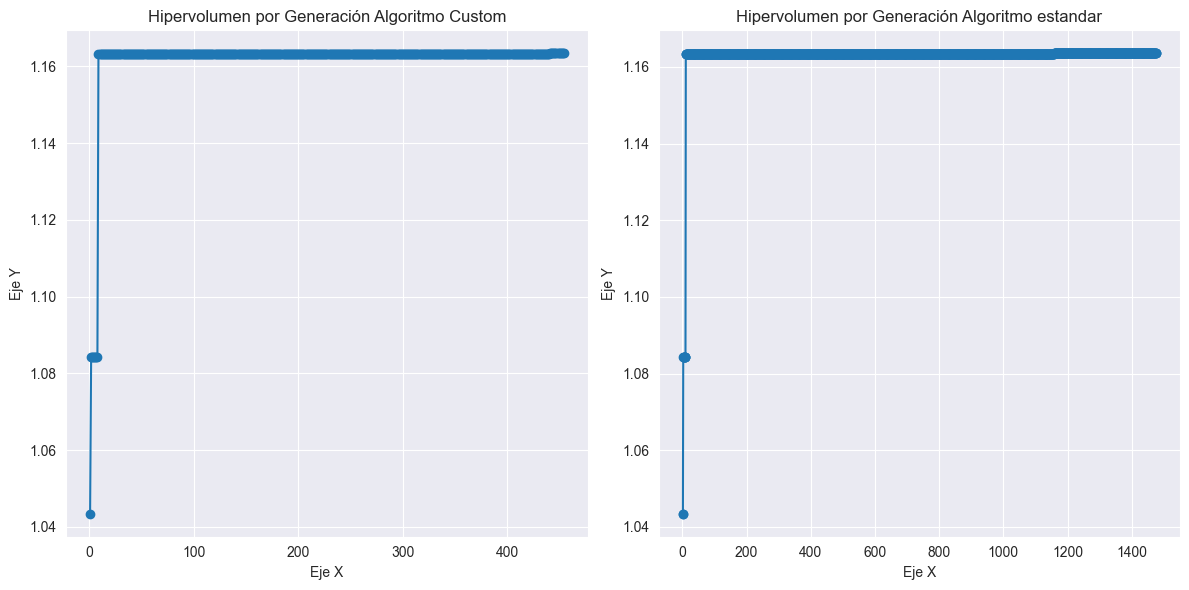

In [31]:
hypervolume_history = np.array(result.algorithm.callback.hypervolume_history)
hypervolume_history1 = np.array(result1.algorithm.callback.hypervolume_history)

# Crear una figura y dos subplots uno al lado del otro
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Graficar en el primer subplot
axs[0].plot(np.arange(1, len(hypervolume_history) + 1), hypervolume_history, marker='o', linestyle='-')
axs[0].set_title('Hipervolumen por Generación Algoritmo Custom')
axs[0].set_xlabel('Eje X')
axs[0].set_ylabel('Eje Y')

# Graficar en el segundo subplot
axs[1].plot(np.arange(1, len(hypervolume_history1) + 1), hypervolume_history1, marker='o', linestyle='-')
axs[1].set_title('Hipervolumen por Generación Algoritmo estandar')
axs[1].set_xlabel('Eje X')
axs[1].set_ylabel('Eje Y')

# Ajustar los subplots para evitar superposiciones
plt.tight_layout()
plt.grid(True)
# Mostrar la figura
plt.show()

Para hacer una comparación donde las 3 dimensiones esten a la misma escala, se deben de normalizar los resultados obteenidos y tras ello sacar el hipervolumen. Para ello se hara uso del modulo preprocessing del paquete sklearn. La normalización se realizara mediante un reescalado a norma unitaria, el cual presenta las siguientes ventajas:
   - Útil cuando la magnitud absoluta de las características no es relevante para el modelo.
   - Útil cuando se quiere mantener la dirección y la relación entre las características, pero se desea eliminar la influencia de la magnitud.
   - Útil cuando se están utilizando algoritmos que se basan en la distancia entre los puntos. En resumen, la normalización a norma unitaria es preferible cuando se quiere mantener la dirección y la relación entre las características sin considerar su magnitud absoluta, especialmente en algoritmos basados en distancias, el cual es nuestro caso.

In [32]:
array1 = np.abs(result.pop.get("F"))
array2 = np.abs(result1.pop.get("F"))
# Apilar verticalmente los dos arrays
array_concatenado = np.vstack((array1, array2))
# Normalizar los valores de cada columna
array_normalizado = preprocessing.normalize(array_concatenado,axis=0)
# Devolver las filas correspondientes a los arrays originales con los valores normalizados
filas_array1_normalizado = array_normalizado[:array1.shape[0], :]
filas_array2_normalizado = array_normalizado[array1.shape[0]:, :]
hv = HV(ref_point=[1,1,1]) 
hv_final_1 = hv(filas_array1_normalizado)
hv_final_2 = hv(filas_array2_normalizado)

In [33]:
print(hv_final_1)
print("------------------------------------")
print(hv_final_2)

0.9964521380807314
------------------------------------
0.9807389622627172


# FUNCIONES Y CLASES NECESARIAS PARA EL HEURISTICO

Para este heuristico, trabajaremos con listas puesto que no es necesario hacer uso de numpy debido a que no vamos a utilizar pymoo, el cual depende mucho de la libreria numpy.
Primero de todo presentamos la función para formar los equipos, dado una lista permutada de alumnos configuramos los alumnos en equipos de 4 

In [34]:


def formar_equipos_l(vector_permutacion):
    num_alumnos = len(vector_permutacion)
    equipos = []

    for i in range(0, num_alumnos, 4):
        equipo = vector_permutacion[i:i + 4]
        equipos.append(equipo)

    return equipos


def GH_team_l(ti, R, r_max, r_min, r_mean):
    Ri = R[ti]
    unique_values, counts = np.unique(Ri, return_counts=True)

    # Calculamos AD(ti)
    ADi = (np.max(Ri) - np.min(Ri)) / 2
    # Calculamos GH(ti)
    # Calcular la puntuación técnica más alta y más baja para el equipo i
    max_puntuacion = np.max(Ri)
    min_puntuacion = np.min(Ri)
    #print(f" Puntuaciones max: {max_puntuacion}")
    #print(f" Puntuaciones min: {min_puntuacion}")

    # Excluir las puntuaciones más altas y más bajas del cálculo de GH
    puntuaciones_excluidas = np.setdiff1d(unique_values, [max_puntuacion, min_puntuacion])
    repetidos = unique_values[counts > 1]

    if len(repetidos) > 0:

        # Si hay valores repetidos
        puntuaciones_excluidas = np.append(puntuaciones_excluidas, repetidos[0])

        # Si el valor se repite 4 veces, lo agregamos dos veces a puntuaciones_excluidas
        if counts[0] == 4:
            puntuaciones_excluidas = np.append(puntuaciones_excluidas, repetidos[0])

        elif np.any(counts == 3):
            puntuaciones_excluidas = np.append(puntuaciones_excluidas, repetidos[0])

        elif len(repetidos) > 1:
            # Si hay más de un valor repetido, agregamos el segundo valor repetido como puntuación excluida
            puntuaciones_excluidas = np.append(puntuaciones_excluidas, repetidos[1])

    #print(f" Puntuaciones excluidas: {puntuaciones_excluidas}")
    restas = np.abs(ADi - puntuaciones_excluidas)
    GHi = (np.max(Ri) - np.min(Ri)) / (1 + np.sum(restas))
    #print(f"GHi: {GHi}")

    AD_max = (r_max - r_min) / 2
    restas_max = AD_max - r_mean
    GHi_max = (r_max - r_min) / (1 + np.abs(2 * restas_max))
    #print(f"GHi_max: {GHi_max}")
    return GHi / GHi_max


def P_team_l(ti, K):
    Ki = K[ti]
    # Calculamos el vector P
    suma_perfiles = np.sum(Ki, axis=0)
    num_alumnos = np.shape(Ki)[0]

    # Inicializamos el vector P_k
    P_k = np.zeros_like(suma_perfiles)

    # Si todos tienen el mismo perfil le damos un 0 en esa dimensión
    P_k[np.abs(suma_perfiles) == num_alumnos] = 0

    # Si todos menos un individuo tienen el mismo perfil le damos un 1 a esa dimensión
    P_k[np.abs(suma_perfiles) >= num_alumnos - 2] = 1

    # Para los demás casos le damos un 2 a esa dimensión
    P_k[(np.abs(suma_perfiles) < num_alumnos - 2) & (np.abs(suma_perfiles) > 0)] = 2

    # Calculamos el indice de divergencia psicológica para ese equipo
    P_ti = np.sum(P_k) / 8

    return P_ti


def BG_team_l(ti, G, Prop_clase):
    Gi = G[ti]
    #print(f"Gi: {Gi}")
    Prop_equipo = float(np.mean(Gi))
    BG_ti = 1 - (abs(Prop_clase - Prop_equipo) / max(Prop_clase, 1 - Prop_clase))
    #print(f"Prop clase: {Prop_clase}")
    #print(f"Prop_equipo: {Prop_equipo}")
    return BG_ti


# Función para calcular el fitness unidimensional para una solucion dada mediante la suma ponderada de las 3 funciones objetivo normalizadas
def fitness_sol(equipos, R, r_max, r_min, r_mean, K, G, Prop_aula, pesos):
    fitness_equipos = []

    for j in range(0, len(equipos)):
        ti = equipos[j]
        GH_equipo = GH_team_l(ti, R, r_max, r_min, r_mean)
        P_equipo = P_team_l(ti, K)
        BG_equipo = BG_team_l(ti, G, Prop_aula)
        fitness_equipos.append([GH_equipo, P_equipo, BG_equipo])

    #Normalizamos las columnas para obtener un suma ponderada equitativa
    fitness_equipos = preprocessing.normalize(fitness_equipos, axis=0)
    #AT solucion
    ATs = np.array([sublista[0] for sublista in fitness_equipos])
    AT_sol = np.prod(ATs)
    # P solucion

    Ps = np.array([sublista[1] for sublista in fitness_equipos])
    P_sol = np.prod(Ps)

    #BG solucion

    BGs = np.array([sublista[2] for sublista in fitness_equipos])
    BG_sol = np.prod(BGs)

    fitness_solution = np.dot([AT_sol, P_sol, BG_sol], pesos)

    return fitness_solution


#Función la cual se va a utilizar en la primera busqueda local para obtener el mejor producto de fitness entre dos equipos random que se van a seleccionar
def fitness_equipo(equipo, R, r_max, r_min, r_mean, K, G, Prop_aula, pesos):
    #print(equipo)

    GH_equipo = GH_team_l(equipo, R, r_max, r_min, r_mean)
    #print(f"GH_equipo: {GH_equipo}")
    P_equipo = P_team_l(equipo, K)
    #print(f"P_equipo: {P_equipo}")
    BG_equipo = BG_team_l(equipo, G, Prop_aula)
    #print(f"BG_equipo: {BG_equipo}")

    fitness_team = np.dot([GH_equipo, P_equipo, BG_equipo], pesos)
    #print(fitness_team)
    return fitness_team

### Funcionamiento correcto de la primera busqueda local

    """
    Mediante la elección aleatoria de dos equipos dentro de una solucion dada, obtenemos todas las redistribuciones posibles de los alumnos que presentan los 2 equipos originales. Se va comparando de uno en uno el mejor fitness y tras comprobar todas las redistribuciones posibles nos quedamos con el que mejor fitness tenga.
    """

In [35]:
# Función para obtener redistribuciones únicas
def obtener_redistribuciones_unicas(redistribuciones):
    redistribuciones_unicas = set()
    for redistribucion in redistribuciones:
        redistribucion_ordenada = tuple(sorted(
            redistribucion))  #Lo convertimos en tuple para que sea hasheable y los ordenamos para quedarnos solo con los equipos unicos
        redistribuciones_unicas.add(redistribucion_ordenada)
    return redistribuciones_unicas


### Busquedas locales
def local_search_1(equipos, R, r_max, r_min, r_mean, K, G, Prop_aula, pesos):
    ind1 = rnd.randint(0, len(equipos) - 1)
    equipo1 = equipos[ind1]
    ind2 = rnd.randint(0, len(equipos) - 1)
    while ind2 == ind1:
        ind2 = rnd.randint(0, len(equipos) - 1)
    equipo2 = equipos[ind2]

    # Generar todas las posibles redistribuciones únicas entre los dos equipos

    redistribuciones_unidas = itertools.combinations(equipo1 + equipo2, len(equipo1))
    redistribuciones_unidas_unicas = obtener_redistribuciones_unicas(redistribuciones_unidas)

    mejor_fitness = float('-inf')
    mejores_equipos = None

    for redistribucion_unicas in redistribuciones_unidas_unicas:
        equipo_nuevo_1 = list(redistribucion_unicas)
        #print(f"equipo nuevo 1: {equipo_nuevo_1}")
        equipo_nuevo_2 = list(set(equipo1 + equipo2) - set(redistribucion_unicas))
        #print(f"equipo nuevo 2: {equipo_nuevo_2}")
        fitness_equipo_nuevo_1 = fitness_equipo(equipo_nuevo_1, R, r_max, r_min, r_mean, K, G, Prop_aula, pesos)
        fitness_equipo_nuevo_2 = fitness_equipo(equipo_nuevo_2, R, r_max, r_min, r_mean, K, G, Prop_aula, pesos)
        fitness_prod = fitness_equipo_nuevo_1 * fitness_equipo_nuevo_2

        if fitness_prod > mejor_fitness:
            mejor_fitness = fitness_prod
            mejor_equipo1 = equipo_nuevo_1
            mejor_equipo2 = equipo_nuevo_2

    equipos.remove(equipo1)
    equipos.remove(equipo2)
    equipos.append(mejor_equipo1)
    equipos.append(mejor_equipo2)

    return equipos  #Devolvemos los equipos con la nueva redistribucion de los dos equipos escogidos aleatoriamente


# Función de búsqueda local 2
def local_search_2(solution, fitness_actual, R, r_maximo, r_minimo, r_medio, K, G, Prop_aula_G, pesos):
    best_score = fitness_actual
    # Recorre todos los pares de equipos posibles.
    for i in range(len(solution)):
        #print(f"equipo i:{i}")
        for j in range(i + 1, len(solution)):
            #print(f"equipo j :{j}")
            for k in range(4):
                for l in range(4):
                    # Intercambia dos alumnos entre los equipos i y j.
                    #print(f"original solution: {solution}")
                    new_solution = copy.deepcopy(solution)  # Crear una copia independiente de best_solution
                    new_solution[i][k], new_solution[j][l] = new_solution[j][l], new_solution[i][k]
                    #print(f"new solution: {new_solution}")
                    #print("######################################################")
                    new_score = fitness_sol(new_solution, R, r_maximo, r_minimo, r_medio, K, G, Prop_aula_G, pesos)
                    # Si la nueva solución es mejor, actualiza la mejor solución encontrada.
                    if new_score > best_score:
                        #print(f"best_solution: {new_solution}")
                        #print(f"best_score: {new_score}")
                        return new_solution, new_score
    return solution, fitness_actual
    

# Heuristico

El loop prinipal se basa en realizar la primera busqueda local.Si la solución obtenida mediante esa primera busqueda no es mejor que la original, añadimos + 1 al contador cl y cr, si no se reinicia el contador cl y cr.Se vuelve a realizar el loop principal hasta que cl = nl.Cuando esto ocurra realizamos la busqueda local 2 y reiniciamos el contador cl.Si el contador cr llega al valor nr, se termina el loop.

In [36]:
class Heuristico:

    def __init__(self,
                 n_alumnos,
                 R,
                 K,
                 G,
                 ):

        self.n_alumnos = n_alumnos
        self.nr = 1.5 * n_alumnos / 4
        self.nl = self.nr / 6
        self.R = R[:n_alumnos + 1]
        self.K = K[:n_alumnos + 1]
        self.G = G[:n_alumnos + 1]
        self.r_maximo = np.max(self.R)
        self.r_minimo = np.min(self.R)
        self.r_medio = np.mean(self.R)
        self.Prop_aula_G = Prop_aula(self.G)

    def do(self, pesos, time_limit, *args, **kwargs):

        elapsed_time = 0
        start_time = time.time()  #Comienza a contar el tiempo

        cl = 0  # Contador de iteraciones no mejoradoras antes del student swap
        cr = 0  # Contador de iteraciones no mejoradas consecutivas
        i = 0

        # Creamos una lista de números del 1 al n_alumnos
        lista_numeros = list(range(1, self.n_alumnos + 1))

        # Ahora lista_numeros es una lista permutada aleatoria
        rnd.shuffle(lista_numeros)

        sol_actual = formar_equipos_l(lista_numeros)  # Formamos los equipos de 4 integrantes
        best_solution = sol_actual
        fitness_actual = fitness_sol(sol_actual, self.R, self.r_maximo, self.r_minimo, self.r_medio, self.K, self.G,
                                     self.Prop_aula_G, pesos)
        best_fitness = fitness_actual
        while elapsed_time < time_limit:

            i = i + 1
            #print(f"Iteración: {i}")
            #print(f"cl: {cl}")
            #print(f"cr: {cr}")
            # Aplicar el primer vecindario de búsqueda local
            #print(f"solucion antes de search 1: {sol_actual}")
            #print(f"fitness antes de search 1: {fitness_actual}")
            sol_actual = local_search_1(sol_actual, self.R, self.r_maximo, self.r_minimo, self.r_medio, self.K, self.G,
                                        self.Prop_aula_G, pesos)
            #print(f"solucion tras search 1: {sol_actual}")
            # Comprobar si se ha encontrado una solución mejor
            fitness_actual = fitness_sol(sol_actual, self.R, self.r_maximo, self.r_minimo, self.r_medio, self.K, self.G,
                                         self.Prop_aula_G, pesos)
            #print(f"fitness tras el search 1: {fitness_actual}")
            # Si se han realizado nl iteraciones no mejoradoras, aplicar el segundo vecindario
            if (cl >= self.nl) and (fitness_actual < best_fitness):
                #print(f"solucion antes de search 2: {sol_actual}")  
                #print(f"fitness antes el search 2: {fitness_actual}")
                sol_actual, fitness_actual = local_search_2(sol_actual, fitness_actual, self.R, self.r_maximo,
                                                            self.r_minimo, self.r_medio, self.K, self.G,
                                                            self.Prop_aula_G, pesos)
                #print(f"solucion tras el search 2: {sol_actual}") 
                #print(f"fitness tras el search 2: {fitness_actual}")
                cl = 0

            if fitness_actual > best_fitness:
                best_solution = sol_actual
                best_fitness = fitness_actual
                #print(f"nueva mejor sol encontrada: {best_solution}")
                #print(f"nueva mejor fit encontrada: {best_fitness}")
                cl = 0
                cr = 0
                #print("Reset contadores!")

            else:
                cl += 1
                cr += 1

            #print(f"mejor sol actual: {best_solution}")
            #print(f"Fitness mejor actual: {best_fitness}")

            elapsed_time = time.time() - start_time
            #print(f"iteracion {i}, tiempo ejecutado: {elapsed_time}")

        #print(f"Solucion final: {list(itertools.chain(*best_solution))}")
        #print(f"Fitness final: {best_fitness}")                                
        return list(itertools.chain(*best_solution))

    def multid_fit(self, sol_final, *args, **kwargs):

        sol_final = formar_equipos_l(sol_final)
        fitness_equipos = []
        #print(f"sol final: {sol_final}")
        #print(f"len sol: {len(sol_final)}")
        for j in range(0, len(sol_final)):
            ti = sol_final[j]
            GH_equipo = GH_team_l(ti, self.R, self.r_maximo, self.r_minimo, self.r_medio)
            P_equipo = P_team_l(ti, K)
            BG_equipo = BG_team_l(ti, self.G, self.Prop_aula_G)
            fitness_equipos.append([GH_equipo, P_equipo, BG_equipo])

        #AT solucion
        ATs = np.array([sublista[0] for sublista in fitness_equipos])
        #print(f"ATs: {ATs}")
        AT_sol = np.prod(ATs)
        #print(f"AT_sol: {AT_sol}")
        # P solucion    
        Ps = np.array([sublista[1] for sublista in fitness_equipos])
        # print(f"Ps: {Ps}")
        P_sol = np.prod(Ps)
        #print(f"P_sol: {P_sol}")
        #BG solucion
        BGs = np.array([sublista[2] for sublista in fitness_equipos])
        #print(f"BGs: {BGs}")
        BG_sol = np.prod(BGs)
        #print(f"BG_sol: {BG_sol}")
        fitness_solution = np.array([-AT_sol, -P_sol, -BG_sol])

        return fitness_solution

In [37]:
#Generamos los pesos para crear una población de soluciones a comparar con el algoritmo multiobjetivo
def generar_pesos():
    # Generar pesos aleatorios asegurando que sumen 1
    pesos = np.random.rand(3)
    pesos = pesos / np.sum(pesos)
    return pesos

# Experimentación

In [38]:
configuraciones = [[50,40, R14,K, G14, "00:01:00", 1.2 ],
                       [50,40, R24,K, G24, "00:01:00", 1.2],
                       [50,52, R14,K, G24, "00:01:30", 1.8],
                       [50,52, R24,K, G14, "00:01:30", 1.8],
                       [50,60, R14, K, G14, "00:02:00", 2.4],
                       [50,60, R24, K, G24, "00:02:00", 2.4]]

In [39]:
hv = HV(ref_point=[1,1,1])

i = 1
warnings.filterwarnings("ignore")
for configuracion in configuraciones:
    # Crear el problema y el algoritmo con los hiperparámetros sugeridos
    pop,n_var, R,K, G, tiempo_ejec, tiempo_heur = configuracion
    
    #Inicializamos las listas de resultados para cada configuración
    hvs = []
    hvs_simple = []
    hvs_heur = []
    hvs_random = []
    
    hvs_norm = []
    hvs_simple_norm = []
    hvs_heur_norm = []
    hvs_random_norm = []
    
    
        
    problema= TFP(n_var, R, K, G)
    
    # Crear una instancia de la clase PermutationSampling
    n_samples = pop
    sampling = PermutationSampling(problema, n_samples)
    algoritmo_nsga2 = NSGA2(
    pop_size=pop,
    sampling = sampling,
    crossover = CustomCrossover(prob = 0.7717895293001165),
    mutation = CustomMutation(prob = 0.057513732052917474),
    survival = RankAndCrowding(crowding_func="mnn"),
    eliminate_duplicates = True)
    
    algoritmo_nsga2_simple = NSGA2(
    pop_size=pop,
    sampling = sampling,
    crossover = CutAndCrossfillCrossover(prob = 0.7717895293001165),
    mutation = InversionMutation(prob =0.057513732052917474),
    survival = RankAndCrowding(crowding_func="mnn"),
    eliminate_duplicates = True)
    
    Heuristic = Heuristico(n_alumnos = n_var,R = R,K = K,G = G)
        
    #Cada instancia la ejecutamos 50 veces
    for j in range(50):
        
        print(f"config {i}")
        print(f"ejecucion: {j}")
        
        # Ejecutamos el algoritmo personalizado
        result = minimize(problema,algoritmo_nsga2,("time", tiempo_ejec), verbose=False)
        
        # Ejecutamos el algoritmo estandar
        result_simple = minimize(problema,algoritmo_nsga2_simple,("time", tiempo_ejec), verbose=False) 
        #Ejecutamos el heuristico simple
        
        # Generar 50 conjuntos aleatorios de pesos
        pesos_por_ejecucion = [generar_pesos() for _ in range(pop)]
        
        fitness_P_heuristico = np.empty(np.shape(pesos_por_ejecucion))
        for k, weights in enumerate(pesos_por_ejecucion):
            sol = Heuristic.do(pesos = weights,time_limit =tiempo_heur)
            fitness_P_heuristico[k] =Heuristic.multid_fit(sol)  
            
        # Ejecutamos la busqueda aleatoria
        a = sampling._do(problema, n_samples) 
        result_random = problema.evaluate(a) 
        # Obtenemos solamente las soluciones no dominadas de las poblaciones finales
        
        non_dom_idx = NonDominatedSorting().do(result.pop.get("F"), only_non_dominated_front=True)
        Fit_final = result.pop.get("F")[non_dom_idx]
        hv_final = hv(Fit_final)
        
        non_dom_idx = NonDominatedSorting().do(result_simple.pop.get("F"), only_non_dominated_front=True)
        Fit_final1 = result_simple.pop.get("F")[non_dom_idx]
        hv_final_1 = hv(Fit_final1)
        
        non_dom_idx = NonDominatedSorting().do(fitness_P_heuristico, only_non_dominated_front=True)
        Fit_final2 = fitness_P_heuristico[non_dom_idx]
        hv_final_2 = hv(Fit_final2)
        
        non_dom_idx = NonDominatedSorting().do(result_random, only_non_dominated_front=True)
        Fit_final_random = result_random[non_dom_idx]
        hv_final_random = hv(Fit_final_random)
        
        
        # Apilar verticalmente los tres arrays para luego poder normalizarlos
        array_concatenado = np.vstack((Fit_final, Fit_final1, Fit_final2, Fit_final_random))
        # Normalizar los valores de cada columna
        array_normalizado = preprocessing.normalize(array_concatenado,axis=0)
        
        # Devolver las filas correspondientes a los arrays originales con los valores normalizados
        len_FF = Fit_final.shape[0]
        Fit_final_normalizado = array_normalizado[:len_FF, :]
        #print(f"len ffn: {len_FF}")
        #print(f"len ffn: {Fit_final_normalizado}")
        hv_final_norm = hv(Fit_final_normalizado)
                       
        len_FF1 =  len_FF + Fit_final1.shape[0]
        Fit_final1_normalizado = array_normalizado[len_FF:len_FF1, :]
        #print(f"len ffn1: {len_FF1}")
        #print(f"len ffn1: {Fit_final1_normalizado}")
        hv_final_1_norm = hv(Fit_final1_normalizado)
        
        len_FF2 =  len_FF1 + Fit_final2.shape[0]
        Fit_final2_normalizado = array_normalizado[len_FF1:len_FF2, :]
        #print(f"len ffn2: {len_FF2}")
        #print(f"len ffn2: {Fit_final2_normalizado}")
        hv_final_2_norm = hv(Fit_final2_normalizado)
        
        Fit_final_random_normalizado = array_normalizado[len_FF2:, :]
        #print(f"len ffn3: {Fit_final_random.shape[0]}")
        #print(f"len ffn3: {Fit_final_random_normalizado}")
        hv_final_random_norm = hv(Fit_final_random_normalizado)
         
            
        #Guardamos las  hv normalizados en nuestra lista de resultados
        hvs.append(hv_final)
        hvs_simple.append(hv_final_1)
        hvs_heur.append(hv_final_2)
        hvs_random.append(hv_final_random)  
       
        #Guardamos las  hv normalizados en nuestra lista de resultados
        hvs_norm.append(hv_final_norm)
        hvs_simple_norm.append(hv_final_1_norm)
        hvs_heur_norm.append(hv_final_2_norm)
        hvs_random_norm.append(hv_final_random_norm)
    
    Pop_final = result.pop.get("X")
    Pop_final1 = result_simple.pop.get("X")
    Pop_final_random = a
    
    nombre_archivo = f"Resultados/Config {i}/hvs_config_{i}.csv"
    np.savetxt(nombre_archivo, np.array(hvs), delimiter=",")
    nombre_archivo = f"Resultados/Config {i}/hvs_norm_config_{i}.csv"
    np.savetxt(nombre_archivo, np.array(hvs_norm), delimiter=",")
    nombre_archivo = f"Resultados/Config {i}/F_config_{i}.csv"
    np.savetxt(nombre_archivo, Fit_final, delimiter=",")
    nombre_archivo = f"Resultados/Config {i}/X_config_{i}.csv"
    np.savetxt(nombre_archivo, Pop_final, delimiter=",")

    nombre_archivo = f"Resultados/Config {i}/hvs_config_simple_{i}.csv"
    np.savetxt(nombre_archivo, np.array(hvs_simple), delimiter=",")
    nombre_archivo = f"Resultados/Config {i}/hvs_norm_config_simple_{i}.csv"
    np.savetxt(nombre_archivo, np.array(hvs_simple_norm), delimiter=",")
    nombre_archivo = f"Resultados/Config {i}/F_config_simple_{i}.csv"
    np.savetxt(nombre_archivo, Fit_final1, delimiter=",")
    nombre_archivo = f"Resultados/Config {i}/X_config_simple_{i}.csv"
    np.savetxt(nombre_archivo, Pop_final1, delimiter=",")
    
    nombre_archivo = f"Resultados/Config {i}/hvs_config_heur_{i}.csv"
    np.savetxt(nombre_archivo, np.array(hvs_heur), delimiter=",")
    nombre_archivo = f"Resultados/Config {i}/hvs_norm_config_heur_{i}.csv"
    np.savetxt(nombre_archivo, np.array(hvs_heur_norm), delimiter=",")
    nombre_archivo = f"Resultados/Config {i}/F_config_heur_{i}.csv"
    np.savetxt(nombre_archivo, Fit_final2, delimiter=",")
    
    nombre_archivo = f"Resultados/Config {i}/hvs_config_random_{i}.csv"
    np.savetxt(nombre_archivo, np.array(hvs_random), delimiter=",")
    nombre_archivo = f"Resultados/Config {i}/hvs_norm_config_random_{i}.csv"
    np.savetxt(nombre_archivo, np.array(hvs_random_norm), delimiter=",")
    nombre_archivo = f"Resultados/Config {i}/F_config_random_{i}.csv"
    np.savetxt(nombre_archivo, Fit_final_random, delimiter=",")
    nombre_archivo = f"Resultados/Config {i}/X_config_random_{i}.csv"
    np.savetxt(nombre_archivo, Pop_final_random, delimiter=",")

    i += 1


config 1
ejecucion: 0


KeyboardInterrupt: 

In [40]:
hvs_1=  pd.DataFrame(np.loadtxt("Resultados/Config 1/hvs_norm_config_1.csv", delimiter=','))
hvs_2=  pd.DataFrame(np.loadtxt("Resultados/Config 2/hvs_norm_config_2.csv", delimiter=','))
hvs_3=  pd.DataFrame(np.loadtxt("Resultados/Config 3/hvs_norm_config_3.csv", delimiter=','))
hvs_4=  pd.DataFrame(np.loadtxt("Resultados/Config 4/hvs_norm_config_4.csv", delimiter=','))
hvs_5=  pd.DataFrame(np.loadtxt("Resultados/Config 5/hvs_norm_config_5.csv", delimiter=','))
hvs_6=  pd.DataFrame(np.loadtxt("Resultados/Config 6/hvs_norm_config_6.csv", delimiter=','))

hvs_simple_1=  pd.DataFrame(np.loadtxt("Resultados/Config 1/hvs_norm_config_simple_1.csv", delimiter=','))
hvs_simple_2=  pd.DataFrame(np.loadtxt("Resultados/Config 2/hvs_norm_config_simple_2.csv", delimiter=','))
hvs_simple_3=  pd.DataFrame(np.loadtxt("Resultados/Config 3/hvs_norm_config_simple_3.csv", delimiter=','))
hvs_simple_4=  pd.DataFrame(np.loadtxt("Resultados/Config 4/hvs_norm_config_simple_4.csv", delimiter=','))
hvs_simple_5=  pd.DataFrame(np.loadtxt("Resultados/Config 5/hvs_norm_config_simple_5.csv", delimiter=','))
hvs_simple_6=  pd.DataFrame(np.loadtxt("Resultados/Config 6/hvs_norm_config_simple_6.csv", delimiter=','))

hvs_heur_1=  pd.DataFrame(np.loadtxt("Resultados/Config 1/hvs_norm_config_heur_1.csv", delimiter=','))
hvs_heur_2=  pd.DataFrame(np.loadtxt("Resultados/Config 2/hvs_norm_config_heur_2.csv", delimiter=','))
hvs_heur_3=  pd.DataFrame(np.loadtxt("Resultados/Config 3/hvs_norm_config_heur_3.csv", delimiter=','))
hvs_heur_4=  pd.DataFrame(np.loadtxt("Resultados/Config 4/hvs_norm_config_heur_4.csv", delimiter=','))
hvs_heur_5=  pd.DataFrame(np.loadtxt("Resultados/Config 5/hvs_norm_config_heur_5.csv", delimiter=','))
hvs_heur_6=  pd.DataFrame(np.loadtxt("Resultados/Config 6/hvs_norm_config_heur_6.csv", delimiter=','))

hvs_random_1=  pd.DataFrame(np.loadtxt("Resultados/Config 1/hvs_norm_config_random_1.csv", delimiter=','))
hvs_random_2=  pd.DataFrame(np.loadtxt("Resultados/Config 2/hvs_norm_config_random_2.csv", delimiter=','))
hvs_random_3=  pd.DataFrame(np.loadtxt("Resultados/Config 3/hvs_norm_config_random_3.csv", delimiter=','))
hvs_random_4=  pd.DataFrame(np.loadtxt("Resultados/Config 4/hvs_norm_config_random_4.csv", delimiter=','))
hvs_random_5=  pd.DataFrame(np.loadtxt("Resultados/Config 5/hvs_norm_config_random_5.csv", delimiter=','))
hvs_random_6=  pd.DataFrame(np.loadtxt("Resultados/Config 6/hvs_norm_config_random_6.csv", delimiter=','))

In [41]:
hvs_1['Alg'] = "NSGA-II Custom"
hvs_2['Alg'] = "NSGA-II Custom"
hvs_3['Alg'] = "NSGA-II Custom"
hvs_4['Alg'] = "NSGA-II Custom"
hvs_5['Alg'] = "NSGA-II Custom"
hvs_6['Alg'] = "NSGA-II Custom"

hvs_simple_1['Alg'] = "NSGA-II Standard"
hvs_simple_2['Alg'] = "NSGA-II Standard"
hvs_simple_3['Alg'] = "NSGA-II Standard"
hvs_simple_4['Alg'] = "NSGA-II Standard"
hvs_simple_5['Alg'] = "NSGA-II Standard"
hvs_simple_6['Alg'] = "NSGA-II Standard"

hvs_heur_1['Alg'] = "Heuristic"
hvs_heur_2['Alg'] = "Heuristic"
hvs_heur_3['Alg'] = "Heuristic"
hvs_heur_4['Alg'] = "Heuristic"
hvs_heur_5['Alg'] = "Heuristic"
hvs_heur_6['Alg'] = "Heuristic"

hvs_random_1['Alg'] = "Random search"
hvs_random_2['Alg'] = "Random search"
hvs_random_3['Alg'] = "Random search"
hvs_random_4['Alg'] = "Random search"
hvs_random_5['Alg'] = "Random search"
hvs_random_6['Alg'] = "Random search"

algos = [hvs_1, hvs_simple_1, hvs_heur_1, hvs_random_1]
algos2 = [hvs_2, hvs_simple_2, hvs_heur_2, hvs_random_2]
algos3 = [hvs_3, hvs_simple_3, hvs_heur_3, hvs_random_3]
algos4 = [hvs_4, hvs_simple_4, hvs_heur_4, hvs_random_4]
algos5 = [hvs_5, hvs_simple_5, hvs_heur_5, hvs_random_5]
algos6 = [hvs_6, hvs_simple_6, hvs_heur_6, hvs_random_6]

hv_1 = pd.concat(algos)
hv_2 = pd.concat(algos2)
hv_3 = pd.concat(algos3)
hv_4 = pd.concat(algos4)
hv_5 = pd.concat(algos5)
hv_6 = pd.concat(algos6)

hv_1['Algorithm'] = hv_1['Alg']
hv_2['Algorithm'] = hv_2['Alg']
hv_3['Algorithm'] = hv_3['Alg']
hv_4['Algorithm'] = hv_4['Alg']
hv_5['Algorithm'] = hv_5['Alg']
hv_5['Algorithm'] = hv_5['Alg']
hv_6['Algorithm'] = hv_6['Alg']


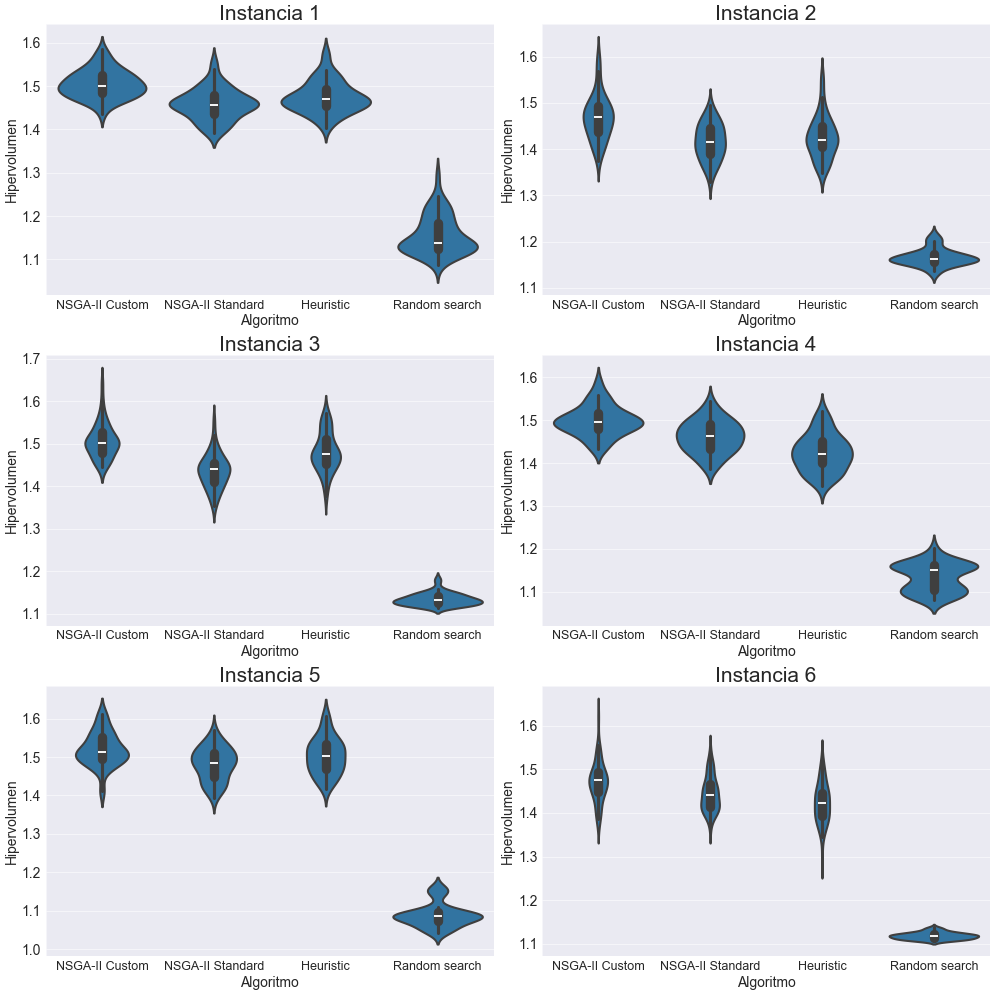

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Suponiendo que tienes tus datos en hv_1, hv_2, ..., hv_6
data = [hv_1, hv_2, hv_3, hv_4, hv_5, hv_6]

# Crear una figura con subplots
fig, axes = plt.subplots(3, 2, figsize=(20, 20), dpi=50)

# Aplanar los ejes para iterar más fácilmente
axes = axes.flatten()

# Iterar sobre cada conjunto de datos y ejes correspondientes
for i, (ax, hv) in enumerate(zip(axes, data), start=1):
    sns.violinplot(x="Alg", y=0, data=hv, linewidth=3, ax=ax)
    ax.set_title(f'Instancia {i}', fontsize=30)
    ax.set_xlabel('Algoritmo', fontsize=20)
    ax.set_ylabel('Hipervolumen', fontsize=20)
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=20)

# Ajustar el layout para que no haya solapamientos
plt.tight_layout()
plt.savefig('Results_juntos.png')
plt.show()


In [45]:
stats.bartlett(hvs_1[0], hvs_simple_1[0], hvs_heur_1[0])

BartlettResult(statistic=0.8441632882332751, pvalue=0.6556805047524701)

In [46]:
#Test de Friedman para ver si hay diferencias significativas estadisticamente
stats.kruskal(hvs_1[0], hvs_simple_1[0], hvs_heur_1[0])

KruskalResult(statistic=39.12834966887419, pvalue=3.1870349522568666e-09)

In [47]:
stats.bartlett(hvs_2[0], hvs_simple_2[0], hvs_heur_2[0])

BartlettResult(statistic=2.174264756968763, pvalue=0.3371820190770089)

In [48]:
#Test de kruskal para ver si hay diferencias significativas estadisticamente
stats.kruskal(hvs_2[0], hvs_simple_2[0], hvs_heur_2[0])


KruskalResult(statistic=31.324884768211916, pvalue=1.577203381253921e-07)

In [49]:
stats.bartlett(hvs_3[0], hvs_simple_3[0], hvs_heur_3[0])

BartlettResult(statistic=1.016693659982401, pvalue=0.6014891211144664)

In [50]:
#Test de kruskal para ver si hay diferencias significativas estadisticamente
stats.kruskal(hvs_3[0], hvs_simple_3[0], hvs_heur_3[0])

KruskalResult(statistic=54.88786225165563, pvalue=1.2057357844526144e-12)

In [51]:
stats.bartlett(hvs_4[0], hvs_simple_4[0], hvs_heur_4[0])

BartlettResult(statistic=2.269997036498375, pvalue=0.3214225976022337)

In [52]:
#Test de kruskal para ver si hay diferencias significativas estadisticamente
stats.kruskal(hvs_4[0], hvs_simple_4[0], hvs_heur_4[0])

KruskalResult(statistic=56.47705430463577, pvalue=5.447076575570922e-13)

In [53]:
stats.bartlett(hvs_5[0], hvs_simple_5[0], hvs_heur_5[0])

BartlettResult(statistic=0.542418987270487, pvalue=0.7624567498364657)

In [54]:
#Test de kruskal para ver si hay diferencias significativas estadisticamente
stats.kruskal(hvs_5[0], hvs_simple_5[0], hvs_heur_5[0])

KruskalResult(statistic=14.323199999999986, pvalue=0.0007758122600320099)

In [55]:
stats.bartlett(hvs_6[0], hvs_simple_6[0], hvs_heur_6[0])

BartlettResult(statistic=1.6753762484042218, pvalue=0.43270973912613464)

In [56]:
#Test de kruskal para ver si hay diferencias significativas estadisticamente
stats.kruskal(hvs_6[0], hvs_simple_6[0], hvs_heur_6[0])

KruskalResult(statistic=25.62290860927152, pvalue=2.729330260644995e-06)